# Area Detector, Single mode, HDF5 file

**Objective**

The [EPICS area detector](https://areadetector.github.io/master/index.html) software has a `Single` mode that reduces the configuration steps needed to acquire image frame(s) and output file(s).  (EPICS Area Detector will write each frame to a separate file.)

Here, we show how to configure the EPICS controls, then acquire an image with [bluesky](https://blueskyproject.io/) and write it to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.

**Contents**

- [EPICS Area Detector IOC](#EPICS-Area-Detector-IOC) is pre-built
- [File Directories](#File-Directories) are different on IOC and bluesky workstation
- [ophyd](#ophyd) to describe the hardware
- [bluesky](#bluesky) for the measurement
- [databroker](#databroker) to view the image
- [punx](#punx) (not part of Bluesky) to look at the HDF5 file
- [Recapitulation](#Recapitulation) - rendition with no explanations

In other examples (such as AD with [default file names](./de_0_adsim_hdf5_basic.ipynb) or [custom file names](./de_1_adsim_hdf5_custom_names.ipynb)), we described the details of the area detector support.  Refer to those examples for the details.  Here, following the same general outline, we leverage that knowledge and proceed to the specifics for this example.

## EPICS Area Detector IOC

This example uses a prebuilt [ADSimDetector](https://areadetector.github.io/master/ADSimDetector/simDetector.html) driver, packaged in a [docker](https://www.docker.com/) image
([prjemian/custom-synapps-6.2-ad-3.10](https://hub.docker.com/r/prjemian/custom-synapps-6.2-ad-3.10/tags)).  The [EPICS IOC](https://docs.epics-controls.org/projects/how-tos/en/latest/getting-started/creating-ioc.html) is configured with prefix `ad:` using the [bash shell script](https://github.com/prjemian/epics-docker/blob/main/v1.1/n6_custom_areaDetector/start_adsim.sh):

```bash
user@workstation:~$ start_adsim.sh ad
```

In [1]:
IOC = "ad:"

## File Directories

Files from the IOC are mounted on the docker host in the directory `/tmp/docker_ioc/iocad`. The bluesky session runs on the docker host.

system | file directory
--- | ---
area detector IOC | `/tmp`
bluesky | `/tmp/docker_ioc/iocad/tmp`

In [2]:
import pathlib

# These paths are specific to how this IOC is implemented.
AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

Next, define some structures that we will use when constructing the detector object.  The `IMAGE_DIR` describes our default choice for where to store image files.  We can change this at run time by changing thearea detector file writer's  `FilePath` PV (before starting image acquisition).

In [3]:
IMAGE_DIR = "example/%Y/%m/%d"  # our choice for file arrangement

# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

## ophyd

Here's a screen view of the configuration we want (`HDF` plugin on the left,
`cam` plugin on the right):

![Area Detector configuration for writing HDF5 files in Single mode](ad_hdf5_single_mode.png)

### Preparation

Configure how [matplotlib](https://matplotlib.org/) charts will be displayed in the notebook.

We'll import additional libraries as needed by each of the following steps.

In [4]:
# matplotlib graphics, choices include: inline, notebook, auto
%matplotlib inline

import matplotlib.pyplot as plt

plt.ion()  # turn on matplotlib plots

### cam

The `cam` Device describes the EPICS area detector camera driver for this detector.  Here we use the `SimDetectorCam` (ADSimDetector) but you could use just about any other supported Cam instead.

In [5]:
from apstools.devices import CamMixin_V34
from ophyd.areadetector import SimDetectorCam

class TheDetectorCam(CamMixin_V34, SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs.update(
            dict(
                acquire_time=0.01,
                acquire_period=0.015,  # a wee bit longer than acquire_time
                num_images=1,
                num_exposures=1,  # Exp./image
                wait_for_plugins="Yes",
                array_callbacks="Enable",
            )
        )

### HDF5

The `hdf1` Device describes the HDF5 File Writing plugin for this detector.  With `FileStoreHDF5SingleIterativeWrite`, you will get a single HDF5 file for each frame you acquire (_n_ frames, _n_ files).

In [6]:
from ophyd.areadetector.filestore_mixins import FileStoreHDF5SingleIterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin
import warnings


class CustomHDF5Plugin(FileStoreHDF5SingleIterativeWrite, HDF5Plugin):
    """
    Add data acquisition methods to HDF5Plugin.

    * ``stage()`` - prepare device PVs before data acquisition
    * ``unstage()`` - restore device PVs after data acquisition
    * ``generate_datum()`` - coordinate image storage metadata
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs.update(
            dict(
                array_callbacks="Disable",
                auto_increment="Yes",
                auto_save="Yes",
                blocking_callbacks="No",
                compression="zlib",
                lazy_open="Yes",
                store_perform="No",
                zlevel=6,
            )
        )
        # capture is not used with Single mode
        # parent.cam.array_callbacks is staged once in the cam
        # create_directory must be set before file_path, which is set before staging
        remove_these = """
            capture
            array_counter
            parent.cam.array_callbacks
            create_directory
        """.split()
        for k in remove_these:
            if k in self.stage_sigs:
                self.stage_sigs.pop(k)

    def stage(self):
        # Again, do not press the Capture button in the HDF plugin
        if "capture" in self.stage_sigs:
            warnings.warn("Do not use capture with file_write_mode='Single'")
            self.stage_sigs.pop("capture")
        super().stage()

### detector

The detector class, a subclass of `DetectorBase`, brings together the detector driver `cam` and plugins.

In [7]:
from apstools.devices import SingleTrigger_V34
from ophyd import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin

class CustomDetector(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(TheDetectorCam, "cam1:")
    hdf1 = ADComponent(
        CustomHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

With all the above setup, create the Python detector object, `adsimdet` and wait for it to connect with EPICS.

In [8]:
adsimdet = CustomDetector(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)

Check that all plugins used by the IOC have been defined in the Python structure.  Expect that this function returns an empty list: `[]`.

In [9]:
adsimdet.missing_plugins()

[]

We must configure `adsimdet` so the HDF5 plugin (by its attribute name `hdf1`) will be called during `adsimdet.read()`, as used by data acquisition.

In [10]:
adsimdet.read_attrs.append("hdf1")

Configure the HDF5 plugin so it will create up to 5 subdirectories for the image directory.

In [11]:
adsimdet.hdf1.create_directory.put(-5)

*Prime* the HDF5 plugin, if necessary.

In [12]:
from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2

# this step is needed for ophyd
if not AD_plugin_primed(adsimdet.hdf1):
    print(f"Priming {adsimdet.hdf1.dotted_name}")
    AD_prime_plugin2(adsimdet.hdf1)

Check how `adsim` is [staged](https://blueskyproject.io/ophyd/user_v1/explanations/staging.html) (configured for data acquisition).

In [13]:
adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])

In [14]:
# adsimdet.cam.stage_sigs["num_images"] = 1  # default is 1
adsimdet.cam.stage_sigs

OrderedDict([('acquire_time', 0.01),
             ('acquire_period', 0.015),
             ('num_images', 1),
             ('num_exposures', 1),
             ('wait_for_plugins', 'Yes'),
             ('array_callbacks', 'Enable')])

In [15]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('blocking_callbacks', 'No'),
             ('auto_increment', 'Yes'),
             ('auto_save', 'Yes'),
             ('num_capture', 0),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Single'),
             ('array_callbacks', 'Disable'),
             ('compression', 'zlib'),
             ('lazy_open', 'Yes'),
             ('store_perform', 'No'),
             ('zlevel', 6)])

## bluesky

Within the [Bluesky framework](https://blueskyproject.io/), [bluesky](https://blueskyproject.io/bluesky) is the package that orchestrates the data acquisition steps, including where to direct acquired data for storage.  [Later](#databroker), we'll use [databroker](https://blueskyproject.io/databroker) to access the image data.

First, setup the RunEngine object `RE`.

In [16]:
import bluesky

RE = bluesky.RunEngine()

### databroker (as RunEngine subscriber)

Setup the databroker (with a temporary databroker catalog) as a subscriber to the documents published from the bluesky `RunEngine`.

In [17]:
import databroker

cat = databroker.temp().v2  # or use your own catalog: databroker.catalog["CATALOG_NAME"]
cat = databroker.catalog["training"]
RE.subscribe(cat.v1.insert)

0

***Take an image with the area detector***

Finally, we are ready to acquire an image.  We'll use the standard bluesky [count()](https://blueskyproject.io/bluesky/generated/bluesky.plans.count.html#bluesky.plans.count) plan.  Also add some metadata about this image.

In [18]:
import bluesky.plans as bp

uids = RE(
    bp.count([adsimdet],
    md=dict(
        title="Area Detector, Single mode, HDF5 file",
        purpose="image")
    )
)

## databroker

Here we show how to access and display the acquired image using databroker as the interface to the data files and run metadata.

First, find the run we just acquired.  We'll index to that run using the `uid` returned by the above call to `RE()`.

In [19]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='6780800e-b08a-4933-bf26-8618b3fb53ed'
  exit_status='success'
  2022-09-30 16:31:38.860 -- 2022-09-30 16:31:38.965
  Streams:
    * primary


***Get the image frame from the run***

Combining several steps into one line, extract the image frame from the run.  We know the image data is in the `primary` stream, that the image is recorded under the name `"adsimdet_image"` (or `adsimdet.image.name`), and the `image` frame is the last two indices.

Import [hdf5plugin](https://hdf5plugin.readthedocs.io), a library that supports advanced compression modes for data in HDF5 files.  (We don't have to call any of its modules directly.  The `import hdf5plugin` will install entry points needed when the supported compression modes are called.)  We did not need this previously since it was the IOC that wrote the  HDF5 file with the chosen compression mode.

NOTE: Any Python client that reads data compressed with these compression modes will also need to import the `hdf5plugin` library, or provide alternative support.

NOTE: Make sure you are using at least version 0.0.10 (or higher) of the [area-detector-handlers](https://github.com/bluesky/area-detector-handlers/pull/32)
for an important bugfix relating to how databroker will read these HDF5 files.


In [20]:
import hdf5plugin  # required for LZ4, Blosc, and other compression codecs

frame = run.primary.read()[adsimdet.image.name][0][0]
frame

<xarray.DataArray 'adsimdet_image' (dim_1: 1024, dim_2: 1024)>
array([[ 9, 10, 11, ...,  6,  7,  8],
       [10, 11, 12, ...,  7,  8,  9],
       [11, 12, 13, ...,  8,  9, 10],
       ...,
       [ 6,  7,  8, ...,  3,  4,  5],
       [ 7,  8,  9, ...,  4,  5,  6],
       [ 8,  9, 10, ...,  5,  6,  7]], dtype=uint8)
Coordinates:
    time     float64 1.665e+09
Dimensions without coordinates: dim_1, dim_2
Attributes:
    object:   adsimdet

### Visualize the image

The `frame` is an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), which has a method to visualize the data as shown here:

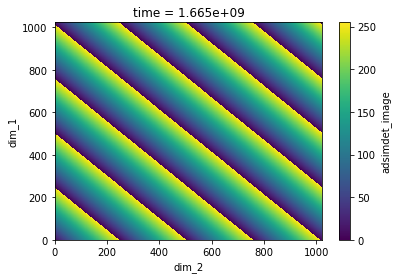

In [21]:
frame.plot.pcolormesh()

### Where is the image file on disk?

So far, we have not had to know the name of the file on disk with the image data.  Still, we can learn about that from the run's metadata, by querying one of its internal structures.

In [22]:
rsrc = run.primary._resources[0]
rsrc

Resource({'path_semantics': 'posix',
 'resource_kwargs': {'filename': '62e73032-4d57-4e37-b784',
                     'frame_per_point': 1,
                     'template': '%s%s_%6.6d.h5'},
 'resource_path': 'tmp/docker_ioc/iocad/tmp/example/2022/09/30',
 'root': '/',
 'run_start': '6780800e-b08a-4933-bf26-8618b3fb53ed',
 'spec': 'AD_HDF5_SINGLE',
 'uid': 'e00f8f86-4dbe-46c1-959e-3d504986b7f5'})

This information has shown the path to the image file *as seen from the bluesky workstation's file system.*  We can parse this structure for the file name. In this case, the file is found since the `resource_path` is written relative to the `READ_PATH_TEMPLATE` defined [above](#File-Directories).  It takes a bit of work to re-assemble the file name.

This is an important distinction since the IOC and bluesky see the same file on different directory paths, as described [above](#File-Directories).

In [23]:
file_name = pathlib.Path(
    rsrc["resource_kwargs"]["template"] % (
        f"{rsrc['root']}{rsrc['resource_path']}/",
        rsrc["resource_kwargs"]["filename"],
        rsrc["resource_kwargs"]["frame_per_point"] - 1
    )
)
print(f"{file_name.exists()=}\n{file_name=}")

file_name.exists()=True
file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/30/62e73032-4d57-4e37-b784_000000.h5')


Alternatively, get the name of the image file on the bluesky (local) workstation from the `adsimdet` object.

NOTE: This method relies on information currently defined in EPICS, via the `adsimdet.hdf1`, so it may not be successful if the HDF plugin has been changed since the image was acquired.

In [24]:
from apstools.devices import AD_full_file_name_local

local_file_name = AD_full_file_name_local(adsimdet.hdf1)
print(f"{local_file_name.exists()=}\n{local_file_name=}")
local_file_name == file_name  # compare the two names

local_file_name.exists()=True
local_file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/30/62e73032-4d57-4e37-b784_000000.h5')


True

## punx

Next, we demonstrate access to the HDF5 image file using the [punx](https://punx.readthedocs.io) program, showing the tree structure of the data file (the image data may be found at HDF5 address `/entry/data/data`, another reference to the exact same data is found at `/entry/instrument/detector/data`):

In [25]:
from apstools.utils import unix

for line in unix(f"punx tree {file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/docker_ioc/iocad/tmp/example/2022/09/30/62e73032-4d57-4e37-b784_000000.h5 : NeXus data file
  entry:NXentry
    @NX_class = "NXentry"
    data:NXdata
      @NX_class = "NXdata"
      data:NX_UINT8[1024,1024] = __array
        __array = [
            [9, 10, 11, '...', 8]
            [10, 11, 12, '...', 9]
            [11, 12, 13, '...', 10]
            ...
            [8, 9, 10, '...', 7]
          ]
        @NDArrayDimBinning = [1 1]
        @NDArrayDimOffset = [0 0]
        @NDArrayDimReverse = [0 0]
        @NDArrayNumDims = 2
        @signal = 1
    instrument:NXinstrument
      @NX_class = "NXinstrument"
      NDAttributes:NXcollection
        @NX_class = "NXcollection"
        @hostname = "zap"
        NDArrayEpicsTSSec:NX_UINT32 = 1033421498
          @NDAttrDescription = "The NDArray EPICS timestamp seconds past epoch"
          @NDAttrName = "NDArrayEpicsTSSec"
          @NDAttrSource = "Driver"
          @NDAttrSo

## Recapitulation

Let's gather the above parts together as one would usually write code.

```py
# matplotlib graphics, choices include: inline, notebook, auto
%matplotlib auto

from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2
from apstools.devices import CamMixin_V34
from apstools.devices import SingleTrigger_V34
import hdf5plugin  # required for LZ4, Blosc, and other compression codecs
from ophyd import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SimDetectorCam
from ophyd.areadetector.filestore_mixins import FileStoreHDF5SingleIterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin
import bluesky
import bluesky.plans as bp
import databroker
import matplotlib.pyplot as plt
import pathlib
import warnings

plt.ion()  # turn on matplotlib plots

RE = bluesky.RunEngine()
cat = databroker.temp().v2
# or use your own catalog like this example:
# cat = databroker.catalog["training"]
RE.subscribe(cat.v1.insert)

IOC = "ad:"

# These paths are specific to how this IOC is implemented.
AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

IMAGE_DIR = "example/%Y/%m/%d"  # our choice for file arrangement

# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"


class TheDetectorCam(CamMixin_V34, SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs.update(
            dict(
                acquire_time=0.01,
                acquire_period=0.015,  # a wee bit longer than acquire_time
                num_images=1,
                num_exposures=1,  # Exp./image
                wait_for_plugins="Yes",
                array_callbacks="Enable",
            )
        )


class CustomHDF5Plugin(FileStoreHDF5SingleIterativeWrite, HDF5Plugin):
    """
    Add data acquisition methods to HDF5Plugin.

    * ``stage()`` - prepare device PVs before data acquisition
    * ``unstage()`` - restore device PVs after data acquisition
    * ``generate_datum()`` - coordinate image storage metadata
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs.update(
            dict(
                array_callbacks="Disable",
                auto_increment="Yes",
                auto_save="Yes",
                blocking_callbacks="No",
                compression="zlib",
                lazy_open="Yes",
                store_perform="No",
                zlevel=6,
            )
        )
        # capture is not used with Single mode
        # parent.cam.array_callbacks is staged once in the cam
        # create_directory must be set before file_path, which is set before staging
        remove_these = """
            capture
            array_counter
            parent.cam.array_callbacks
            create_directory
        """.split()
        for k in remove_these:
            if k in self.stage_sigs:
                self.stage_sigs.pop(k)

    def stage(self):
        # Again, do not press the Capture button in the HDF plugin
        if "capture" in self.stage_sigs:
            warnings.warn("Do not use capture with file_write_mode='Single'")
            self.stage_sigs.pop("capture")
        super().stage()


class CustomDetector(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(TheDetectorCam, "cam1:")
    hdf1 = ADComponent(
        CustomHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")


adsimdet = CustomDetector(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)
adsimdet.missing_plugins()
adsimdet.read_attrs.append("hdf1")
adsimdet.hdf1.create_directory.put(-5)
NUM_FRAMES = 1
adsimdet.cam.stage_sigs["num_frames"] = NUM_FRAMES

# this step is needed for ophyd
if not AD_plugin_primed(adsimdet.hdf1):
    print(f"Priming {adsimdet.hdf1.dotted_name}")
    AD_prime_plugin2(adsimdet.hdf1)


uids = RE(
    bp.count([adsimdet],
    md=dict(
        title="Area Detector, Single mode, HDF5 file",
        purpose="image")
    )
)

run = cat.v2[uids[0]]
frame = run.primary.read()[adsimdet.image.name][0][0]

frame.plot.pcolormesh()  # show the image
```